# Interactive parameter estimation example

Let's say you have some data you would really like to replicate through your computational model. But... how can you do that?

- [Introduction](#parameter-space-exploration)
- [Interactive 3D exploration](#interactive-preview)

In [2]:
%matplotlib notebook
import time as tm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits import mplot3d
import mpl_toolkits.mplot3d.art3d as art3d

<a id='parameter-space-exploration'></a>
## 📚 A bried introduction to parameter estimation

PhysiCell is a big model and it may difficult to learn about parameter optimization AND follow the dynamics of what is happening inside of the model. So, let's keep it cool and start with a simpler problem. We will use the example stated above: **we have some data on the number of cells through time.** 

Now, **we need a model**. We will assume that this data follows a **logistic growth rule**, which we can characterize with three parameters: 
- The initial number of cells, $N_0$;
- The proliferation rate, $r$;
- The carrying capacity, $K$

The logistic growth can be described through the following expression:

$\frac{KN_0}{N_0 + (K-N_0)\exp{(-rt)}}$


### Generating data

*Eh... we don't actually have data?*

The first thing we need is to do is to **generate some data, which we will be using to calibrate our model**. We **could use real data** to calibrate our model, but we do not actually have any, so we will be generating a dataset with a given set of parameters. Then, we will try to **estimate those parameter values through our optimization algorithm**, as we would if we were not sure about their real values.

<AxesSubplot:title={'center':'Generated data'}, xlabel='Time (Days)'>

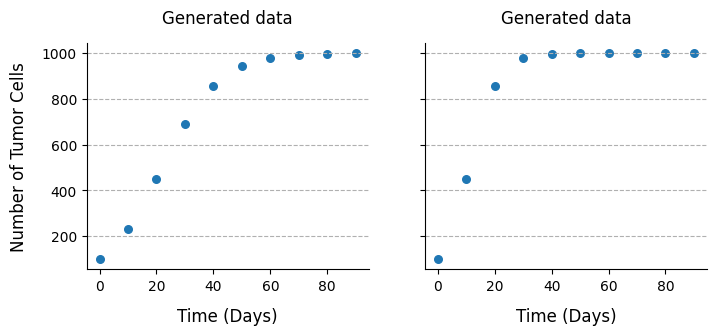

In [2]:
def logistic_growth_model(time, N0, K, r):
    """Returns a NumPy array with the number of cells through time for logistic growth."""
    cells = np.array(np.shape(time))
    cells = K*N0/(N0 + (K-N0)*np.exp(-r*time))
                                                                
    return cells

def plot_growth(time, data, ax, title, ylabel=True):
    """Plots and styles the evolution of cell number through time."""
    ax.scatter(time, data, s=30)
    
    ax.grid(axis='y', linestyle='--')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if ylabel is True:
        ax.set_ylabel('Number of Tumor Cells', fontsize=12, labelpad=10)
        
    ax.set_xlabel('Time (Days)', fontsize=12, labelpad=10)
    ax.set_title(title, fontsize=12, y=1.05)
    
    return ax
    

# Generate logistic growth data
start_time = 0
stop_time = 100
number_time_points = 10
time = np.arange(start_time, stop_time, (stop_time-start_time)/number_time_points)

# Dataset 1
N_0 = 100
proliferation_rate = 0.1
carrying_capacity = 1000

N_data = logistic_growth_model(time, N_0, carrying_capacity, proliferation_rate)

# Dataset 2
proliferation_rate = 0.2
N_data_2 = logistic_growth_model(time, N_0, carrying_capacity, proliferation_rate)


# Plot results
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=100, sharey=True)

plot_growth(time, N_data, axes[0], 'Generated data')
plot_growth(time, N_data_2, axes[1], 'Generated data', ylabel=False)

## Optimization
Now, we are able to generate new data| We will be **using our first dataset as our target data**, which was obtained with the parameter set ($r=0.1; K=1000$). 

### Comparing datasets
Through our optimization process, we will generate new data with some **new parameter values** and assess if the results are similar to our target data. Based on that evaluation, we will be choosing a new set of parameters, in order to **minimize the difference between our datasets**. 

In this example, we will consider the **sum of the squared differences** between the target data and the new data. Let's compare the two datasets we generated before:

In [3]:
def sum_squared_diff(model_data, reference_data):
    """Returns the summ of the squared differences between model and reference data."""
    error = ((model_data - reference_data)**2).sum()
    
    return error

diff = sum_squared_diff(N_data, N_data_2)
print(f'Difference between datasets: {diff}')

Difference between datasets: 319750.4944647962


This value tells us **how much our datasets differ**, and so we can conclude that **the parameters do not match exactly**, as we have a large difference value. However, it doesn't provide us with any information on how to get closer to the target value. Thus, **we need to test multiple parameter sets**, and then choose the one that minimizes the difference.

In [4]:
# Lower proliferation (closer to target)
proliferation_rate = 0.15
N_data_3 = logistic_growth_model(time, N_0, carrying_capacity, proliferation_rate)

diff = sum_squared_diff(N_data, N_data_3)
print(f'Difference between datasets (r={proliferation_rate}): {diff}')

# Higher proliferation
proliferation_rate = 0.3
N_data_3 = logistic_growth_model(time, N_0, carrying_capacity, proliferation_rate)

diff = sum_squared_diff(N_data, N_data_3)
print(f'Difference between datasets (r={proliferation_rate}): {diff}')

Difference between datasets (r=0.15): 132868.67411711058
Difference between datasets (r=0.3): 607278.9243607549


In this case, we conclude that a proliferation rate of 0.15 gives us the best results, for now, and that high proliferation rates tend to result in larger differences. Hence, **we probably should look for lower proliferation rates!**

Yet, here we are focusing on one parameter, but we have two... So, the best option is to **vary both of them** and evaluate the results.

### Building a parameter search grid
Let's start by creating a **search grid** that will **define the range of values we will be testing**. For each combination of this grid, we will **create a new dataset**, **compare the results** to our target data and **store the difference value**. Based on that, we will choose the parameters that better replicate the target data.

To build this grid, we need to define the **center value** (we will go with our best result yet, ($r=0.15; K=1000$), as well as the **number of points we want to evaluate** for each parameter, and h**ow much we want to vary the parameter values**.

In [5]:
points_per_direction = 8
percent_per_direction = 0.5
about_point = np.array([0.15, 1000])

# Create structures to store data
parameters_in_sweep = np.zeros((2,1))
objective_function = np.zeros((points_per_direction, points_per_direction))
save_x = np.zeros((1, points_per_direction))
save_y = np.zeros((1, points_per_direction))

# Defining search bounds
factor = percent_per_direction
# Proliferation rate bounds
min_prol_limit = about_point[0]-factor*about_point[0]
max_prol_limit = about_point[0]+factor*about_point[0]
prol_sweep = np.linspace(min_prol_limit, max_prol_limit, points_per_direction)
# Carrying capacity bounds 
min_carcap_limit = about_point[1]-factor*about_point[1]
max_carcap_limit = about_point[1]+factor*about_point[1]
carcap_sweep = np.linspace(min_carcap_limit, max_carcap_limit, points_per_direction)

save_x = prol_sweep
save_y = carcap_sweep

# Sweep through the parameter combinations
for a in range(points_per_direction):
    for b in range(points_per_direction):

        # Select parameters and run the model
        parameters_in_sweep[0] = prol_sweep[a]
        parameters_in_sweep[1] = carcap_sweep[b]
        N_model = logistic_growth_model(time, N_0, parameters_in_sweep[1], parameters_in_sweep[0])

        # Compute error
        objective_function[a][b] = sum_squared_diff(N_model, N_data)

# Select best point in the parameter space
# I is optimal index, but in references to a points_per_direction X points_per_direcion
I = np.argmin(objective_function)
x = int(np.floor(I/points_per_direction))
y = int(I-points_per_direction*x)

about_point[0] = prol_sweep[x]
about_point[1] = carcap_sweep[y]

new_x, new_y = [round(about_point[0], 4), round(about_point[1], 4)]
error = objective_function.min()

print(f'Best value found for parameters: ({new_x}, {new_y}); error: {error}')

Best value found for parameters: (0.0964, 1071.4286); error: 21922.635235464462


**We were able to get closer to our target values!** Since we have all the data stored, let's take a look at how the difference values vary based on the parameters values.

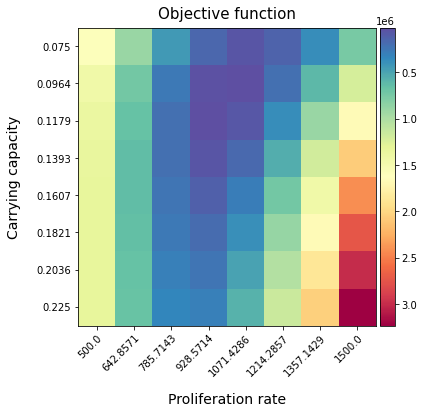

In [6]:
# Plot the objective function
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(objective_function, cmap='Spectral_r')

# Show color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cax.yaxis.set_label('Difference between datasets')
plt.colorbar(im, cax=cax)

# Assign the right parameter values to the grid
ax.set_xticks(np.arange(len(save_y)))
ax.set_yticks(np.arange(len(save_x)))

ax.set_xticklabels(np.round(save_y, 4))
ax.set_yticklabels(np.round(save_x, 4))

# Set labels
ax.set_ylabel('Carrying capacity', labelpad=15, fontsize=14)
ax.set_xlabel('Proliferation rate', labelpad=15, fontsize=14)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title('Objective function', y=1.01, fontsize=15)

plt.gca().invert_yaxis()

fig.tight_layout()
plt.show()

<a id='interactive-preview'></a>
### Multilevel search
We could take this approach further by **performing another grid search**, using our new best point as the center point, and adjusting the grid size to **consider new points that may have been overlooked in the previous search**. This is the approach we used to build the PhysiCOOL multilevel sweep.

At each level, we will be using the same strategy we used before. However, **we will be decreasing the search range** by setting a new factor, which reduces the range of the search grid **based on the current level**.

In [7]:
number_of_levels = 7
points_per_direction = 10
percent_per_direction = 0.5
about_point = np.array([0.08, 1100.0])

# Create structures to store data
parameters_in_sweep = np.zeros((2,1))
objective_function = np.zeros((number_of_levels, points_per_direction, points_per_direction))
save_x = np.zeros((number_of_levels, points_per_direction))
save_y = np.zeros((number_of_levels, points_per_direction))

for n in range(number_of_levels):
    
    # Defining search bounds
    factor = percent_per_direction/(n*2+1)
    # Proliferation rate bounds
    min_prol_limit = about_point[0]-factor*about_point[0]
    max_prol_limit = about_point[0]+factor*about_point[0]
    prol_sweep = np.linspace(min_prol_limit, max_prol_limit, points_per_direction)
    # Carrying capacity bounds 
    min_carcap_limit = about_point[1]-factor*about_point[1]
    max_carcap_limit = about_point[1]+factor*about_point[1]
    carcap_sweep = np.linspace(min_carcap_limit, max_carcap_limit, points_per_direction)
    
    save_x[n] = prol_sweep
    save_y[n] = carcap_sweep
    
    # Sweep through the parameter combinations
    for a in range(points_per_direction):
        for b in range(points_per_direction):
            
            # Select parameters and run the model
            parameters_in_sweep[0] = prol_sweep[a]
            parameters_in_sweep[1] = carcap_sweep[b]
            N_model = logistic_growth_model(time, N_0, parameters_in_sweep[1], parameters_in_sweep[0])
            
            # Compute error
            objective_function[n][a][b] = sum_squared_diff(N_model, N_data)

    # Select best point in the parameter space
    # I is optimal index, but in references to a points_per_direction X points_per_direcion
    I = np.argmin(objective_function[n])
    x = int(np.floor(I/points_per_direction))
    y = int(I-points_per_direction*x)
    
    about_point[0] = prol_sweep[x]
    about_point[1] = carcap_sweep[y]
    
    new_x, new_y = [round(about_point[0], 4), round(about_point[1], 4)]
    error = objective_function[n].min()
    
    print(f'New point: {new_x}, {new_y}; error: {round(error, 3)}')

New point: 0.0933, 1038.8889; error: 6454.836
New point: 0.102, 981.1728; error: 1452.895
New point: 0.1008, 992.0748; error: 254.9
New point: 0.1, 999.9484; error: 0.142
New point: 0.0994, 1006.1209; error: 151.741
New point: 0.0999, 1001.0395; error: 4.571
New point: 0.1004, 996.7615; error: 42.337


Once again, we can look into the results we have stored during the optimization process.

<IPython.core.display.Javascript object>


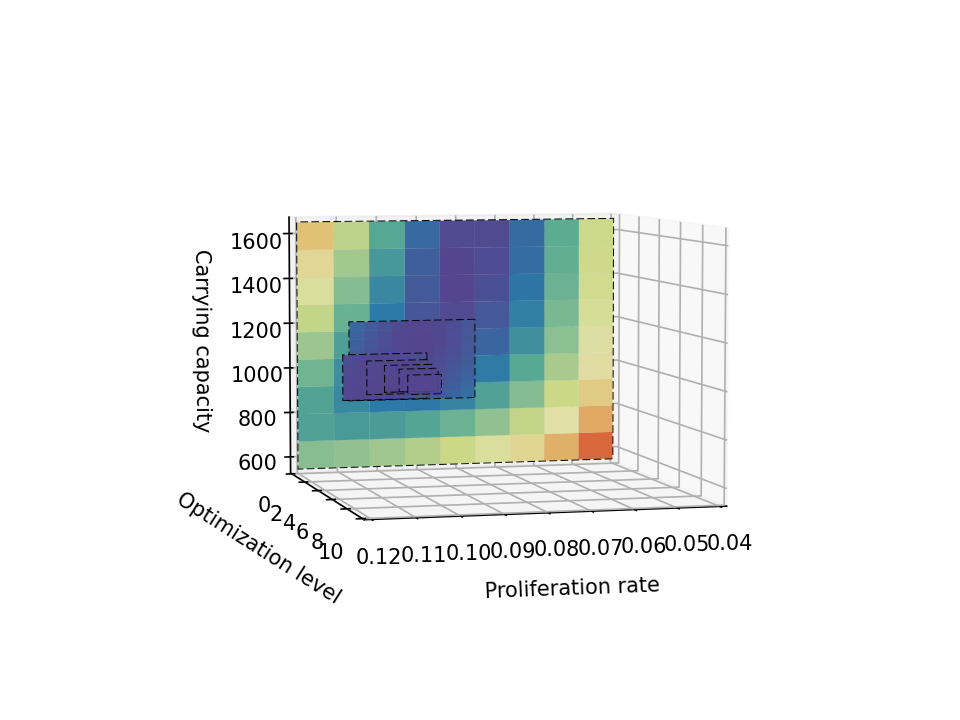

In [8]:
color_dimension = objective_function[0] # change to desired fourth dimension
maxx = color_dimension.max()
minn = 0
norm = colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='Spectral_r')

# Creating figure
fig = plt.figure()
ax = plt.axes(projection ='3d')

ax.view_init(elev=5., azim=75)

plt.ion()
fig.show()
fig.canvas.draw()

ax.set_xlabel('Proliferation rate', labelpad=10)
ax.set_zlabel('Carrying capacity', labelpad=10)
ax.set_ylabel('Optimization level', labelpad=5)

for n in range(number_of_levels):
    
    # Get the parameter space
    x, y = np.meshgrid(save_x[n], save_y[n])
    
    width = max(save_x[n]) - min(save_x[n])
    heigth = max(save_y[n]) - min(save_y[n])
    
    p = Rectangle((min(save_x[n]), min(save_y[n])), width, heigth, 
                  edgecolor='black', facecolor='none', linestyle='--')
    ax.add_patch(p)
    art3d.pathpatch_2d_to_3d(p, z=n, zdir='y')
    
    # Convert the error data to colormap
    color_dimension = objective_function[n] # change to desired fourth dimension
    m.set_array([])
    fcolors = m.to_rgba(color_dimension)
    
    # Plot surface using color as a 4th dimension
    ax.plot_surface(x, np.ones((len(prol_sweep), len(prol_sweep)))*n, y,
                    facecolors=fcolors,
                    edgecolor='white', linewidth=0.1, rstride=1, cstride=1,
                    vmin=minn, vmax=maxx)
    ax.set_ylim(0,10)
    ax.set_xlim(min(save_x[0]), max(save_x[0]))
    ax.set_zlim(min(save_y[0]), max(save_y[0]))
    
    fig.canvas.draw()
    tm.sleep(1)

    ax.set_xlabel('Proliferation rate', labelpad=10)
    ax.set_zlabel('Carrying capacity', labelpad=10)
    ax.set_ylabel('Optimization level', labelpad=5)

#fig.colorbar(m, shrink=0.6)

### Dynamic visualization
For larger models, it may be useful to **plot the objective function while the model is running.** This way, we can evaluate if the model is behaving as expected, and we can avoid having to wait until the model has stopped running to tune our initial parameter values.

<IPython.core.display.Javascript object>


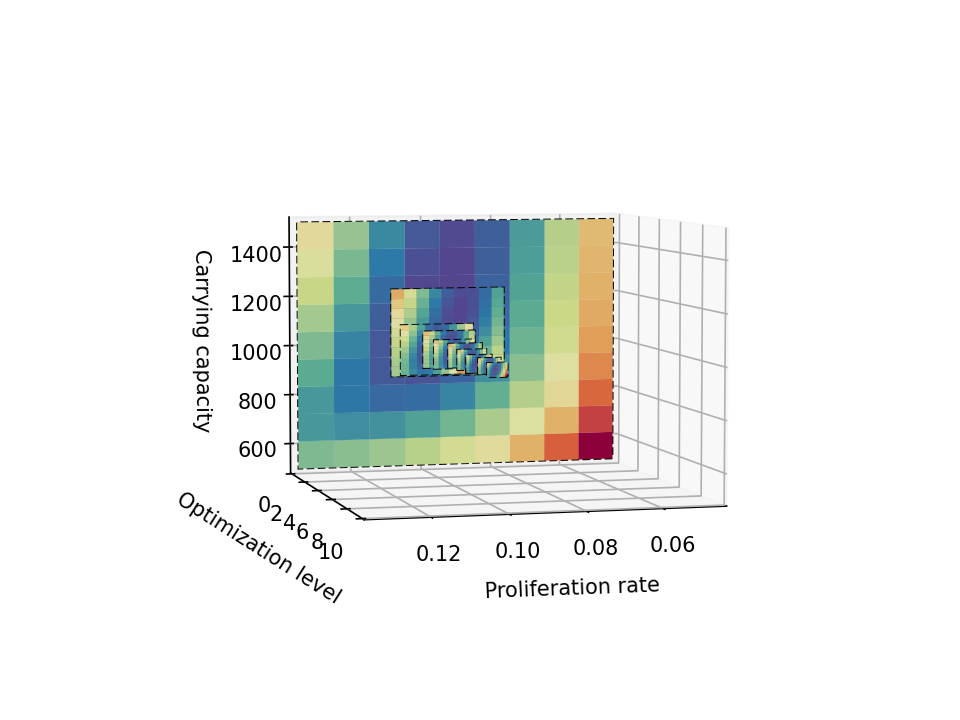

In [9]:
# Creating figure
fig = plt.figure()
ax = plt.axes(projection ='3d')

fig.show()
fig.canvas.draw()

ax.view_init(elev=5., azim=75)

number_of_levels = 10
points_per_direction = 10
percent_per_direction = 0.5
about_point = np.array([0.09, 1000])

parameters_in_sweep = np.zeros((2,1))
objective_function = np.zeros((number_of_levels, points_per_direction, points_per_direction))
save_x = np.zeros((number_of_levels, points_per_direction))
save_y = np.zeros((number_of_levels, points_per_direction))

for n in range(number_of_levels):
    
    # Defining search bounds
    factor = percent_per_direction/(n*2+1)
    # Proliferation rate bounds
    min_prol_limit = about_point[0]-factor*about_point[0]
    max_prol_limit = about_point[0]+factor*about_point[0]
    prol_sweep = np.linspace(min_prol_limit, max_prol_limit, points_per_direction)
    # Carrying capacity bounds 
    min_carcap_limit = about_point[1]-factor*about_point[1]
    max_carcap_limit = about_point[1]+factor*about_point[1]
    carcap_sweep = np.linspace(min_carcap_limit, max_carcap_limit, points_per_direction)
    
    save_x[n] = prol_sweep
    save_y[n] = carcap_sweep
    
    # Sweep through the parameter combinations
    for a in range(points_per_direction):
        for b in range(points_per_direction):
            
            # Select parameters and run the model
            parameters_in_sweep[0] = prol_sweep[a]
            parameters_in_sweep[1] = carcap_sweep[b]
            N_model = logistic_growth_model(time, N_0, parameters_in_sweep[1], parameters_in_sweep[0])
            
            # Compute error
            objective_function[n][a][b] = sum_squared_diff(N_model, N_data)

    # Select best point in the parameter space
    # I is optimal index, but in references to a points_per_direction X points_per_direcion
    I = np.argmin(objective_function[n])
    x = int(np.floor(I/points_per_direction))
    y = int(I-points_per_direction*x)
    
    about_point[0] = prol_sweep[x]
    about_point[1] = carcap_sweep[y]
    
    # Get the parameter space
    x, y = np.meshgrid(save_x[n], save_y[n])
    
    width = max(save_x[n]) - min(save_x[n])
    heigth = max(save_y[n]) - min(save_y[n])
    
    p = Rectangle((min(save_x[n]), min(save_y[n])), width, heigth, 
                  edgecolor='black', facecolor='none', linestyle='--')
    ax.add_patch(p)
    art3d.pathpatch_2d_to_3d(p, z=n, zdir='y')
    
    # Convert the error data to colormap
    color_dimension = objective_function[n] # change to desired fourth dimension
    minn, maxx = color_dimension.min(), color_dimension.max()
    norm = colors.Normalize(minn, maxx)
    m = plt.cm.ScalarMappable(norm=norm, cmap='Spectral_r')
    m.set_array([])
    fcolors = m.to_rgba(color_dimension)
    
    # Plot surface using color as a 4th dimension
    ax.plot_surface(x, np.ones((len(prol_sweep), len(prol_sweep)))*n, y,
                    facecolors=fcolors,
                    edgecolor='white', linewidth=0.1, rstride=1, cstride=1,
                    vmin=minn, vmax=maxx)
    ax.set_ylim(0,10)
    ax.set_xlim(min(save_x[0]), max(save_x[0]))
    ax.set_zlim(min(save_y[0]), max(save_y[0]))
    
    fig.canvas.draw()

    ax.set_xlabel('Proliferation rate', labelpad=10)
    ax.set_zlabel('Carrying capacity', labelpad=10)
    ax.set_ylabel('Optimization level', labelpad=5)
